<a href="https://colab.research.google.com/github/randypausch/ai4trans/blob/main/CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sobhanmoosavi/us-accidents

us-accidents.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip us-accidents.zip

Archive:  us-accidents.zip
replace US_Accidents_Dec21_updated.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [ ]:
df = pd.read_csv('/content/US_Accidents_Dec21_updated.csv')

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

In [ ]:
#Let's take a look at the columns
df.info()
len(df)

In [ ]:
#Let's check any missing data
df.isna().sum()

In [ ]:
#The next columns are Latitudes and Longitudes, it might be hard to use them directly, 
#but I am thinking about using K-means to group them into 10 geo-spacial areas

#Let's look at some sample data first
df[['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng']].head(10)

,Start_Lat,Start_Lng,End_Lat,End_Lng
0,40.108910,-83.092860,40.112060,-83.031870
1,39.865420,-84.062800,39.865010,-84.048730
2,39.102660,-84.524680,39.102090,-84.523960
3,41.062130,-81.537840,41.062170,-81.535470
4,39.172393,-84.492792,39.170476,-84.501798
5,39.063240,-84.032430,39.067310,-84.058510
6,39.775650,-84.186030,39.772750,-84.188050
7,41.375310,-81.820170,41.367860,-81.821740
8,40.702247,-84.075887,40.699110,-84.084293
9,40.109310,-82.968490,40.110780,-82.984000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


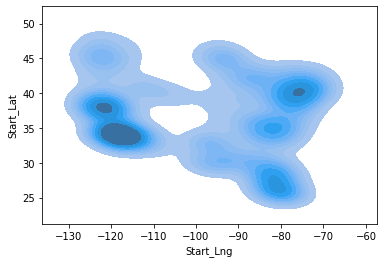

In [ ]:
#Now Let's see if we can use kdeplot on a SAMPLE of df to visualize density of Start_Lng vs. Start_Lat
# df_sample = df.sample(10000)
sns.kdeplot(df['Start_Lng'], df_sample['Start_Lat'], shade = True)

In [ ]:
#Now implement K-means to find 10 clusters
#reference on elbow method (not used here): https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
from sklearn.cluster import KMeans

In [ ]:
X = df[['Start_Lng', 'Start_Lat']]
kmeans = KMeans(n_clusters = 10).fit(X)
geo_cluster = kmeans.fit_predict(X)
df['Geo_Cluster'] = geo_cluster

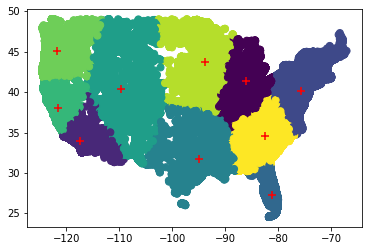

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
centers = kmeans.cluster_centers_
scatter = ax.scatter( df['Start_Lng'], df['Start_Lat'], c=geo_cluster, s=50)
for i, j in centers:
   ax.scatter(i, j, s=50, c='red', marker='+')

plt.show()

In [ ]:
#Now we can drop Start_Lat and Start_Lng
df.drop(['Start_Lat', 'Start_Lng','End_Lat','End_Lng'], axis = 1, inplace = True)

In [ ]:
#Let's look at Start and End time for a sec
from datetime import datetime
df[['Start_Time', 'End_Time']].head()

,Start_Time,End_Time
0,2016-02-08 00:37:08,2016-02-08 06:37:08
1,2016-02-08 05:56:20,2016-02-08 11:56:20
2,2016-02-08 06:15:39,2016-02-08 12:15:39
3,2016-02-08 06:51:45,2016-02-08 12:51:45
4,2016-02-08 07:53:43,2016-02-08 13:53:43


In [ ]:
#The times are pretty close, we might be interested to see the time difference between End_Time and Start_Time

df['Time_Diff'] = (df['End_Time'].astype('datetime64[ns]') - df['Start_Time'].astype('datetime64[ns]'))


In [ ]:
df['Time_Diff'] = df['Time_Diff'].apply(lambda x: x.days * 24 + x.seconds / 3600)

In [ ]:
df['Time_Diff']

0          6.000000
1          6.000000
2          6.000000
3          6.000000
4          6.000000
             ...   
2845337    0.476667
2845338    0.448056
2845339    0.474444
2845340    0.489167
2845341    0.490278
Name: Time_Diff, Length: 2845342, dtype: float64

In [ ]:
#Converting start time into hours
start_hour = df['Start_Time'].astype('datetime64[ns]').dt.hour


In [ ]:
morning = [1 if 6 <= x <= 11 else 0 for x in start_hour]
afternoon = [1 if 12 <= x <= 17 else 0 for x in start_hour]
evening = [1 if 18 <= x <= 24 or 0 <= x <= 5 else 0 for x in start_hour]

In [ ]:
#Now we put them back into df
df = df.assign(Morning = morning, Afternoon = afternoon, Evening = evening)

In [ ]:
#We can drop the Start_Time and End_Time columns now
df.drop(['Start_Time', 'End_Time'], axis = 1, inplace = True)

In [ ]:
#Now let's see accidents distribution by timeframe
temp = np.asarray(morning) + np.asarray(afternoon) * 2 + np.asarray(evening) * 3
timeframe = ['morning' if x == 1 else 'afternoon' if x == 2 else 'evening' for x in temp]
del temp

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


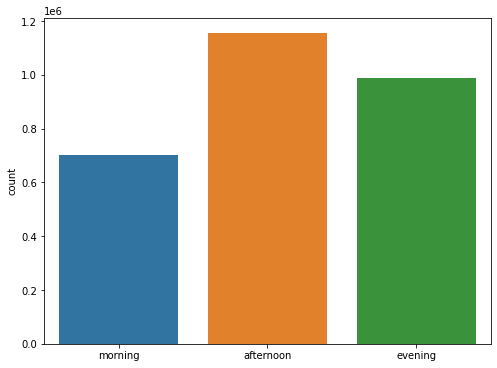

In [ ]:
plt.figure(figsize = (8, 6))
sns.countplot(timeframe, order = ['morning', 'afternoon', 'evening'])
#It seems most accidents happen in the afternoon
#My initial thought is that evening times would have more accidents because of poor lighting but the plot shows otherwise

In [ ]:
#Some columns may have missing value
cols_missing_vals = df.isna().sum()[lambda x: x > 0]
cols_missing_vals


Number                   1743911
Street                         2
City                         137
Zipcode                     1319
Timezone                    3659
Airport_Code                9549
Weather_Timestamp          50736
Temperature(F)             69274
Wind_Chill(F)             469643
Humidity(%)                73092
Pressure(in)               59200
Visibility(mi)             70546
Wind_Direction             73775
Wind_Speed(mph)           157944
Precipitation(in)         549458
Weather_Condition          70636
Sunrise_Sunset              2867
Civil_Twilight              2867
Nautical_Twilight           2867
Astronomical_Twilight       2867
dtype: int64

In [ ]:
#The total # of rows of the df is
num_rows = len(df.index)
num_rows

2845342

In [ ]:
#Let's say we do not want columns that is missing over 5% of the data
cols_to_drop = cols_missing_vals[lambda x: x > num_rows * 0.05]
cols_to_drop

Number               1743911
Wind_Chill(F)         469643
Wind_Speed(mph)       157944
Precipitation(in)     549458
dtype: int64

In [ ]:
#Now drop the columns from df
df.drop(cols_to_drop.index, axis = 1, inplace = True)

In [ ]:
#Missing Value Cols
cols_missing_vals = df.isna().sum()[lambda x: x > 0].index
df[cols_missing_vals].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Street                 object 
 1   City                   object 
 2   Zipcode                object 
 3   Timezone               object 
 4   Airport_Code           object 
 5   Weather_Timestamp      object 
 6   Temperature(F)         float64
 7   Humidity(%)            float64
 8   Pressure(in)           float64
 9   Visibility(mi)         float64
 10  Wind_Direction         object 
 11  Weather_Condition      object 
 12  Sunrise_Sunset         object 
 13  Civil_Twilight         object 
 14  Nautical_Twilight      object 
 15  Astronomical_Twilight  object 
dtypes: float64(4), object(12)
memory usage: 347.3+ MB


In [ ]:
#We would fill missing value cols by data type
def fill_missing_values(col_name):
    #For float64, we fill using median
    if df[col_name].dtype == np.float64:
        df[col_name].fillna(df[col_name].median(), inplace = True)
    #For objects, we use existing distribution
    else:
        nas = df[col_name].isna()
        df.loc[nas, col_name] = df.loc[~nas, col_name].sample(nas.sum(), replace = True).values

In [ ]:
for col_name in cols_missing_vals:
    fill_missing_values(col_name)

In [ ]:
#Now check for columns missing data again
df.isna().any()

ID                       False
Severity                 False
Distance(mi)             False
Description              False
Street                   False
Side                     False
City                     False
County                   False
State                    False
Zipcode                  False
Country                  False
Timezone                 False
Airport_Code             False
Weather_Timestamp        False
Temperature(F)           False
Humidity(%)              False
Pressure(in)             False
Visibility(mi)           False
Wind_Direction           False
Weather_Condition        False
Amenity                  False
Bump                     False
Crossing                 False
Give_Way                 False
Junction                 False
No_Exit                  False
Railway                  False
Roundabout               False
Station                  False
Stop                     False
Traffic_Calming          False
Traffic_Signal           False
Turning_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


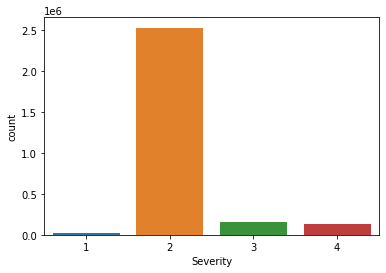

In [ ]:
sns.countplot(df['Severity'])

In [ ]:
df.Severity.value_counts()

2    2532991
3     155105
4     131193
1      26053
Name: Severity, dtype: int64

In [ ]:
#What I am going to do next is to drop the features that we are not going to use in this analysis
df.drop(['Description', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Airport_Code', 'Weather_Timestamp', 
        'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight','ID','Evening','Timezone','Wind_Direction','Weather_Condition'], axis = 1, inplace = True)

In [ ]:
X = df.drop('Severity', axis = 1)
y = df['Severity']

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


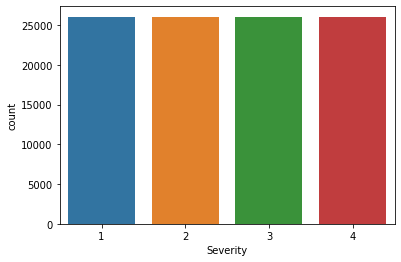

In [ ]:
sns.countplot(y_resampled)

In [ ]:
X_resampled

,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Geo_Cluster,Time_Diff,Morning,Afternoon
0,0.000,103.0,22.0,27.15,10.0,False,False,True,True,False,...,False,False,True,False,True,False,1,0.750000,0,1
1,0.000,95.0,19.0,27.16,10.0,False,False,True,False,False,...,False,False,False,False,True,False,1,0.750000,0,1
2,0.000,68.0,93.0,29.14,9.0,False,False,False,False,False,...,False,False,False,False,False,False,0,0.250000,0,1
3,0.000,98.0,18.0,28.28,10.0,False,False,True,False,False,...,False,False,False,False,True,False,1,0.750000,0,1
4,0.000,95.0,22.0,29.90,10.0,False,False,False,False,True,...,False,False,False,False,False,False,6,0.250000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104207,0.055,29.0,67.0,30.29,10.0,False,False,True,False,False,...,False,False,False,False,False,False,2,0.459444,1,0
104208,2.212,53.0,45.0,26.53,10.0,False,False,False,False,False,...,False,False,False,False,False,False,1,24.855833,0,1
104209,5.309,64.0,67.0,29.82,10.0,False,False,False,False,False,...,False,False,False,False,False,False,2,0.488056,0,1
104210,0.415,77.0,94.0,29.87,7.0,False,False,False,False,False,...,False,False,False,False,False,False,3,0.490833,0,0


In [ ]:
X = X_resampled
y = y_resampled

In [ ]:
bool_cols = X.select_dtypes(include = ['bool']).columns
X.loc[:, bool_cols] = X[bool_cols].astype(int)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72948 entries, 61782 to 70527
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Distance(mi)     72948 non-null  float64
 1   Temperature(F)   72948 non-null  float64
 2   Humidity(%)      72948 non-null  float64
 3   Pressure(in)     72948 non-null  float64
 4   Visibility(mi)   72948 non-null  float64
 5   Amenity          72948 non-null  int64  
 6   Bump             72948 non-null  int64  
 7   Crossing         72948 non-null  int64  
 8   Give_Way         72948 non-null  int64  
 9   Junction         72948 non-null  int64  
 10  No_Exit          72948 non-null  int64  
 11  Railway          72948 non-null  int64  
 12  Roundabout       72948 non-null  int64  
 13  Station          72948 non-null  int64  
 14  Stop             72948 non-null  int64  
 15  Traffic_Calming  72948 non-null  int64  
 16  Traffic_Signal   72948 non-null  int64  
 17  Turning_

In [ ]:
#Standardize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cols_to_scale = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Time_Diff']

scaler.fit(X_train[cols_to_scale])

X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std.loc[:, cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test_std.loc[:, cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [ ]:
X_train_std

,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Geo_Cluster,Time_Diff,Morning,Afternoon
61782,-0.131963,-0.020521,-0.825135,0.263226,0.255514,0,0,0,0,0,...,0,0,0,0,0,0,2,-0.032950,0,1
93519,0.468967,-2.632764,1.066655,0.631761,-0.451002,0,0,0,0,0,...,0,0,0,0,0,0,2,-0.032883,0,0
25769,-0.347058,0.299345,-0.945887,-2.785567,0.255514,0,0,0,0,0,...,0,0,0,0,1,0,5,-0.031567,1,0
92165,0.195687,0.139412,-0.181121,-0.431966,0.255514,0,0,0,0,0,...,0,0,1,0,0,0,9,-0.024991,0,1
95160,-0.179179,-0.980121,-0.905636,0.397238,0.255514,0,0,0,0,0,...,0,0,0,0,0,0,2,-0.032918,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57511,-0.347058,0.619211,0.825150,0.497748,0.255514,0,0,0,0,0,...,0,0,0,0,0,0,9,-0.030251,1,0
87061,-0.100963,0.102094,1.549666,0.539627,-0.804260,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.003948,0,0
30890,-0.328935,0.032790,-0.543379,0.288353,0.255514,0,0,0,0,0,...,0,0,0,0,0,0,6,-0.006535,0,1
6240,-0.347058,-0.447010,-0.261623,-3.112223,0.255514,0,0,0,0,0,...,0,0,0,0,0,0,5,-0.031567,1,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
clf.fit(X_train_std,y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
y_pred = clf.predict(X_test_std)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


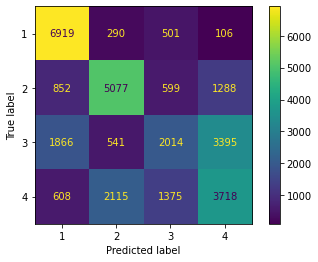

The test accuracy is 0.57


In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
plot_confusion_matrix(clf, X_test_std, y_test)  
plt.show()
print("The test accuracy is {:.2f}".format(accuracy_score(y_test, y_pred))) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


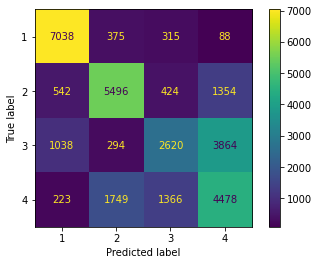

The test accuracy is 0.63


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_std,y_train)
y_pred = clf.predict(X_test_std)
plot_confusion_matrix(clf, X_test_std, y_test)  
plt.show()
print("The test accuracy is {:.2f}".format(accuracy_score(y_test, y_pred))) 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


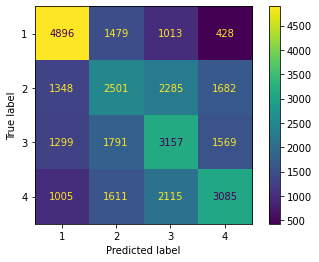

The test accuracy is 0.44


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train_std,y_train)
y_pred = clf.predict(X_test_std)
plot_confusion_matrix(clf, X_test_std, y_test)  
plt.show()
print("The test accuracy is {:.2f}".format(accuracy_score(y_test, y_pred))) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


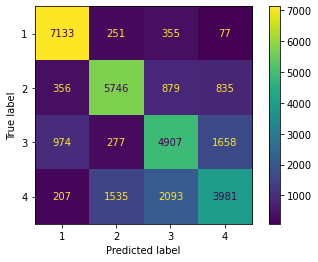

The test accuracy is 0.44


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_std, y_train)
plot_confusion_matrix(clf, X_test_std, y_test)  
plt.show()
print("The test accuracy is {:.2f}".format(accuracy_score(y_test, y_pred))) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


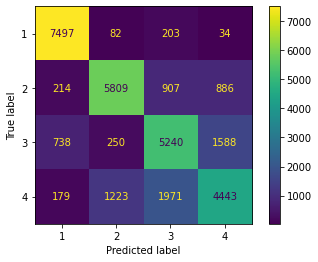

The test accuracy is 0.44


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(max_iter=100).fit(X_train_std, y_train)
plot_confusion_matrix(clf, X_test_std, y_test)  
plt.show()
print("The test accuracy is {:.2f}".format(accuracy_score(y_test, y_pred))) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


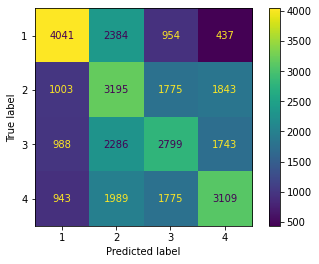

The test accuracy is 0.44


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis().fit(X_train_std, y_train)
plot_confusion_matrix(clf, X_test_std, y_test)  
plt.show()
print("The test accuracy is {:.2f}".format(accuracy_score(y_test, y_pred))) 

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


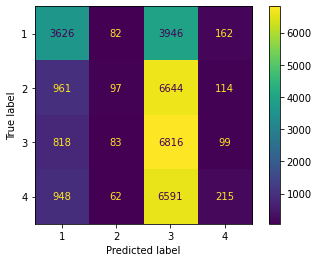

The test accuracy is 0.44


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis().fit(X_train_std, y_train)
plot_confusion_matrix(clf, X_test_std, y_test)  
plt.show()
print("The test accuracy is {:.2f}".format(accuracy_score(y_test, y_pred))) 